Support Vector Machines - Classification (SVC)

# Test 1 : Images size = 32 x 32 & model : kernel=linear & C=5

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pywt


## Parameters

### Path to the images

In [2]:
train_path = "../../../datasets/original/train/"
valid_path = "../../../datasets/original/val/"
test_path = "../../../datasets/original/test/"

### Images size

In [3]:
img_height = 32
img_width = 32

### Model Parameters

In [4]:
C=[5]
kernel=['linear']
coef0=[0]

## Preprocessing : Haar Wavelet

The wavelet transform is a mathematical technique which can decompose a signal into multiple lower resolution levels by controlling the scaling and shifting factors of a single wavelet function

### Methods

In [5]:
def w2d(img, mode='haar', level=1, plotIt=False):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    img_rgb_2_gray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(img_rgb_2_gray)
    imArray /= 255
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    if plotIt:
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 3, 1)
        image_init = img
        plt.title("image_init")
        plt.axis('off')
        plt.imshow(np.squeeze(image_init),cmap='gray',interpolation='nearest')
        plt.subplot(1, 3, 2)
        image_rgb_to_gray = img_rgb_2_gray
        plt.title("image_rgb_to_gray")
        plt.axis('off')
        plt.imshow(np.squeeze(image_rgb_to_gray),cmap='gray',interpolation='nearest')
        plt.subplot(1, 3, 3)
        reconstruction = imArray_H
    
        plt.title("reconstruction")
        plt.axis('off')
        plt.imshow(np.squeeze(reconstruction),cmap='gray',interpolation='nearest')

        plt.tight_layout()
        plt.show()

    return imArray_H

def images_to_array(dataset_name='test', img_height=32, img_width=32):
    if dataset_name == 'test' or dataset_name == 'train' or dataset_name == 'val':
        path_to_data = '../../../datasets/original/' + dataset_name
        folder_name_dict ={}
        X =[]
        y =[]
        imgs_har = []
        import os
        count =0
        for img_folder in os.scandir(path_to_data):
            if img_folder.path.split('/')[-1] != ".DS_Store":
                path_ = img_folder.path
                folder_name = path_.split('/')[-1]
                print(dataset_name + folder_name)
                folder_name_dict[path_.split('/')[-1]] = count

                count = count + 1
                nb_img = 0
                for train_img in os.scandir(path_):
                    if train_img.path.split('/')[-1] != ".DS_Store":
                        nb_img += 1
                        # loads the image and convert it into the 3 channel BGR color image (matrice)
                        img = cv2.imread(train_img.path)

                        # resize the image 32 32*      
                        scalled_raw_img = cv2.resize(img,(img_height,img_width))
                        
                        plotIt=False
                        if nb_img <= 1:
                            plotIt=True
                        
                        if dataset_name=='train':
                            #begin wavelet transform
                            img_har = w2d(scalled_raw_img,'db1',5, plotIt)   
                        else:
                            img_rgb_2_gray = cv2.cvtColor( scalled_raw_img,cv2.COLOR_RGB2GRAY )
                            imArray =  np.float32(img_rgb_2_gray)
                            img_har =  np.uint8(imArray)
                        #resize 
                        scalled_har_img = cv2.resize(img_har,(img_height,img_width)) 
                        #Stack arrays in sequence vertically (row wise).   
                        combined_img = np.vstack((scalled_raw_img.reshape(img_height*img_width*3,1),scalled_har_img.reshape(img_height*img_width*1,1)))
                        X.append(combined_img)
                        y.append(folder_name_dict[path_.split('/')[-1]])
                            
                print(nb_img)
        return (X, y, folder_name_dict)
    else:
        return "Wrong dataset_name"

### Start

testPNEUMONIE
390
testNORMAL
234
trainPNEUMONIE


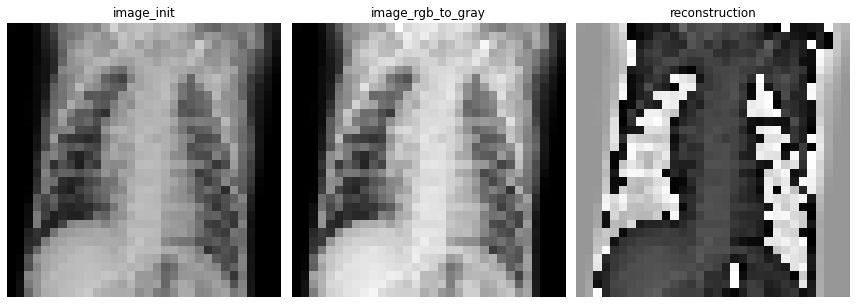

3875
trainNORMAL


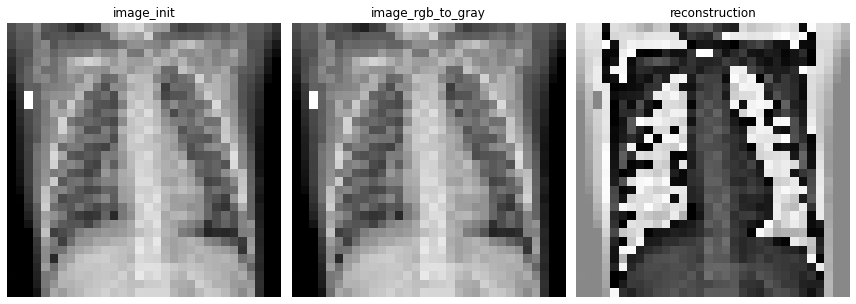

1341
valPNEUMONIE
8
valNORMAL
8


In [6]:
(X_test, y_test, folder_name_dict) = images_to_array('test', img_height, img_width)
(X_train, y_train, folder_name_dict) = images_to_array('train', img_height, img_width)
(X_val, y_val, folder_name_dict) = images_to_array('val', img_height, img_width)

### Dataset output

In [7]:
print(folder_name_dict)

print("X_test len :" + str(len(X_test)))
print("y_test len :" + str(len(y_test)))
print("X_train len :" + str(len(X_train)))
print("y_train len :" + str(len(y_train)))
print("X_val len :" + str(len(X_val)))
print("y_val len :" + str(len(y_val)))
total = len(X_test) + len(X_train) + len(X_val)
print("Test : " + str(round(len(X_test)/total*100, 2)) + "%, Train : " + str(round(len(X_train)/total*100, 2)) + "%, Val : " + str(round(len(X_val)/total*100, 2)) + "%")

{'PNEUMONIE': 0, 'NORMAL': 1}
X_test len :624
y_test len :624
X_train len :5216
y_train len :5216
X_val len :16
y_val len :16
Test : 10.66%, Train : 89.07%, Val : 0.27%


### Resize the arrays

In [8]:
X_test= np.array(X_test).reshape(len(X_test),(img_height * img_width * 4)).astype(float)
X_train= np.array(X_train).reshape(len(X_train),(img_height * img_width * 4)).astype(float)
X_val= np.array(X_val).reshape(len(X_val),(img_height * img_width * 4)).astype(float)

## Train, Test and val

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def model_svm(X_train, y_train, gamma='auto', probability=True, C=[1,5,10], kernel=['linear','rbf'], coef0=[0]):
    model_params ={
        'svm':{
            'model':SVC(gamma=gamma,probability=probability),
            'params':{
                'svc__C':C,
                'svc__kernel':kernel,
                'svc__coef0': coef0
            }
        }
    }
    scores =[]
    best_estimators ={}

    for algo_names, algo in model_params.items():
        pipe = make_pipeline(StandardScaler(), algo['model'])
        clf = GridSearchCV(pipe,algo['params'],cv=5,return_train_score=False)
        clf.fit(X_train,y_train)
        scores.append(
            {
                'model':algo_names,

                'best_score':clf.best_score_,
                'best_params': clf.best_params_
            }
        )
        best_estimators[algo_names] = clf.best_estimator_#returns model with best params
    return (scores, best_estimators)


In [10]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm    0.955523  {'svc__C': 5, 'svc__coef0': 0, 'svc__kernel': ...
SVM test : 
0.8012820512820513
SVM val : 
0.9375


# Test 1.1: Images size = 32 x 32 & model : kernel=rbf & C=5

In [11]:
C=[5]
kernel=['rbf']
coef0=[0]

In [12]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm     0.97316  {'svc__C': 5, 'svc__coef0': 0, 'svc__kernel': ...
SVM test : 
0.7275641025641025
SVM val : 
0.625


# Test 1.1: Images size = 32 x 32 & model : kernel=linear & C=10

In [19]:
C=[10]
kernel=['linear']
coef0=[0]

In [20]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm    0.955523  {'svc__C': 10, 'svc__coef0': 0, 'svc__kernel':...
SVM test : 
0.8012820512820513
SVM val : 
0.9375


# Test 2 : Images size = 40 x 40 & model : kernel=linear & C=10

In [21]:
img_height = 40
img_width = 40

In [22]:
C=[10]
kernel=['linear']
coef0=[0]

testPNEUMONIE
390
testNORMAL
234
trainPNEUMONIE


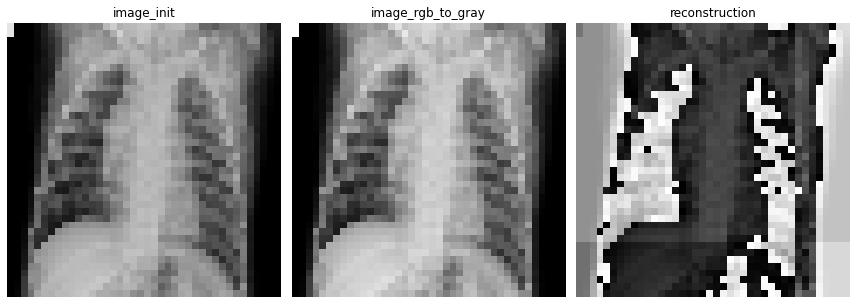

3875
trainNORMAL


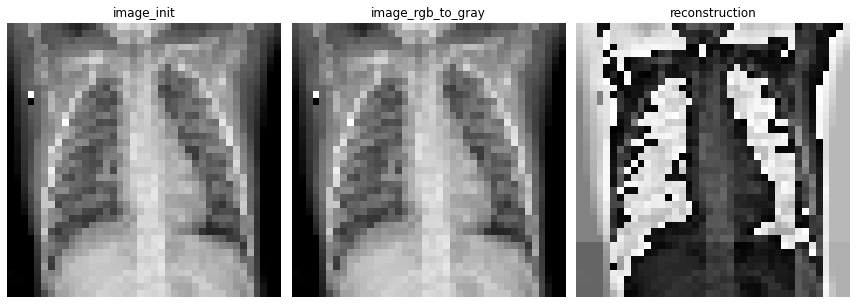

1341
valPNEUMONIE
8
valNORMAL
8


In [23]:
(X_test, y_test, folder_name_dict) = images_to_array('test', img_height, img_width)
(X_train, y_train, folder_name_dict) = images_to_array('train', img_height, img_width)
(X_val, y_val, folder_name_dict) = images_to_array('val', img_height, img_width)

In [24]:
X_test= np.array(X_test).reshape(len(X_test),(img_height * img_width * 4)).astype(float)
X_train= np.array(X_train).reshape(len(X_train),(img_height * img_width * 4)).astype(float)
X_val= np.array(X_val).reshape(len(X_val),(img_height * img_width * 4)).astype(float)

In [25]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm    0.962041  {'svc__C': 10, 'svc__coef0': 0, 'svc__kernel':...
SVM test : 
0.8317307692307693
SVM val : 
0.8125


# Test 3 : Images size = 50 x 50 & model : kernel=linear & C=10

In [26]:
img_height = 50
img_width = 50

In [27]:
C=[10]
kernel=['linear']
coef0=[0]

testPNEUMONIE
390
testNORMAL
234
trainPNEUMONIE


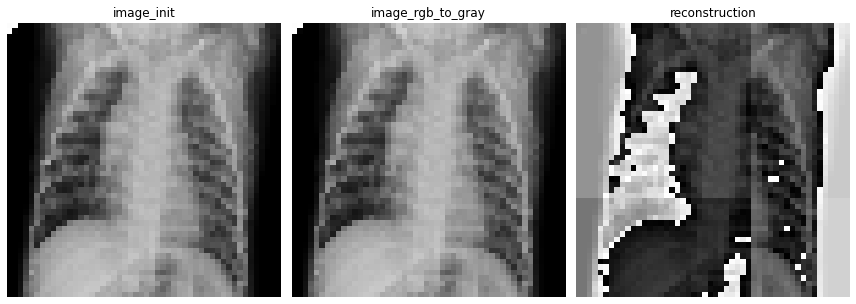

3875
trainNORMAL


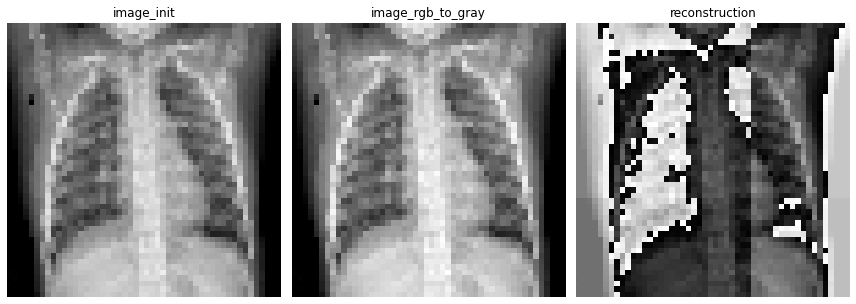

1341
valPNEUMONIE
8
valNORMAL
8


In [28]:
(X_test, y_test, folder_name_dict) = images_to_array('test', img_height, img_width)
(X_train, y_train, folder_name_dict) = images_to_array('train', img_height, img_width)
(X_val, y_val, folder_name_dict) = images_to_array('val', img_height, img_width)

In [29]:
X_test= np.array(X_test).reshape(len(X_test),(img_height * img_width * 4)).astype(float)
X_train= np.array(X_train).reshape(len(X_train),(img_height * img_width * 4)).astype(float)
X_val= np.array(X_val).reshape(len(X_val),(img_height * img_width * 4)).astype(float)

In [30]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm    0.964533  {'svc__C': 10, 'svc__coef0': 0, 'svc__kernel':...
SVM test : 
0.8221153846153846
SVM val : 
0.8125


# Test 4 : Images size = 60 x 60 & model : kernel=linear & C=10

In [31]:
img_height = 60
img_width = 60

In [32]:
C=[10]
kernel=['linear']
coef0=[0]

testPNEUMONIE
390
testNORMAL
234
trainPNEUMONIE


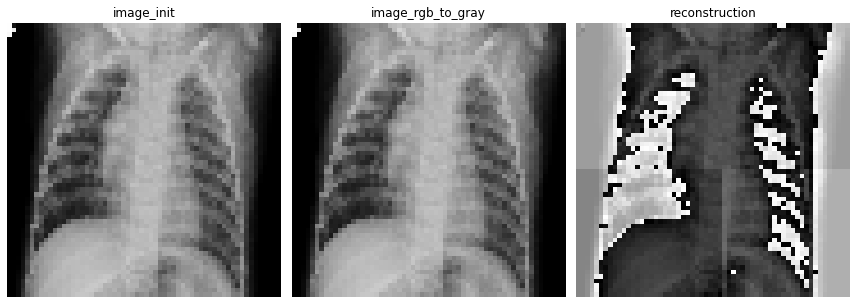

3875
trainNORMAL


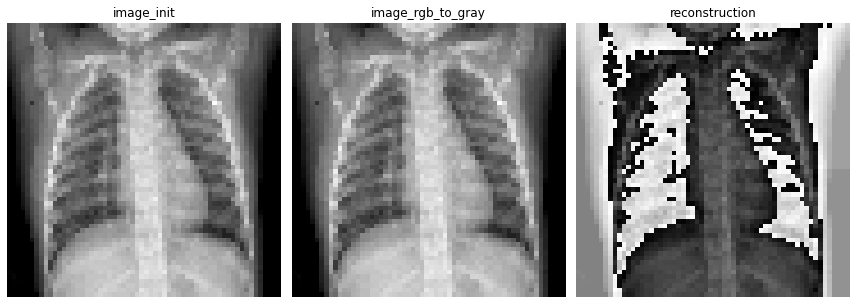

1341
valPNEUMONIE
8
valNORMAL
8


In [33]:
(X_test, y_test, folder_name_dict) = images_to_array('test', img_height, img_width)
(X_train, y_train, folder_name_dict) = images_to_array('train', img_height, img_width)
(X_val, y_val, folder_name_dict) = images_to_array('val', img_height, img_width)

In [34]:
X_test= np.array(X_test).reshape(len(X_test),(img_height * img_width * 4)).astype(float)
X_train= np.array(X_train).reshape(len(X_train),(img_height * img_width * 4)).astype(float)
X_val= np.array(X_val).reshape(len(X_val),(img_height * img_width * 4)).astype(float)

In [35]:
# train
(scores, best_estimators) = model_svm(X_train, y_train, gamma='auto', probability=True, C=C, kernel=kernel, coef0=coef0)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
df = pd.DataFrame(scores,columns=['model','best_score','best_params' ])
print(df)

# test
print("SVM test : ")
print(best_estimators['svm'].score(X_test,y_test))

# val 
print("SVM val : ")
print(best_estimators['svm'].score(X_val,y_val))

  model  best_score                                        best_params
0   svm    0.964341  {'svc__C': 10, 'svc__coef0': 0, 'svc__kernel':...
SVM test : 
0.842948717948718
SVM val : 
0.875
